In [313]:
!pwd

/home/peter/proj/allestm-train/jupyter


In [314]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
import pandas as pd
import json
import pathlib
import math

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve

#mpl.rcParams['figure.dpi'] = 300
#sns.set_style("ticks")

sns.set()
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('Paired', 13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


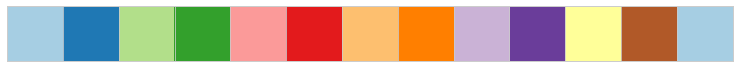

In [315]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

# Config

In [316]:
dataset_name = 'depth'
kind = 'test'#'test' / 'independent_test'
plot_dir = pathlib.Path('../plots/')
file_format = 'png'
savefig_args = {'dpi': 300, 'bbox_inches':'tight'}
two_col_fig_width = 7.5
one_col_fig_width = 3.5

method_mapping = [
    ['observed', 'Observed'],
    ['rf_', 'RF'],
    ['xgb_', 'GBM'],
    ['cnn_', 'conv'],
    ['dcnn_', 'dconv'],
    ['lstm_', 'LSTM'],
    ['blending', 'AllesTM'],
    ['profbval', 'PROFbval'],
    ['spinex', 'SPINE X'],
    ['anglor', 'ANGLOR'],
    ['predyflexy', 'PredyFlexy'],
    ['memsat', 'MEMSAT-SVM'],
    ['polyphobius', 'PolyPhobius'],
    ['prof', 'PROFphd'],
    ['psipred', 'PSIPRED']
]

# Raw data

In [317]:
conn = sqlite3.connect("../data.db")

In [318]:
raw_df = pd.read_sql_query(f"select * from raw_data join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) join proteins using (id)", conn)

In [319]:
raw_df.describe()

,resi,bfactor,phi,psi,acc_chain,acc_complex,tms_nr,re_nr,n_x,n_y,...,c_x,c_y,c_z,length,thickness,resolution,cov_total,cov_trimmed,num_tms,num_res
count,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.00000,56089.000000,56089.000000,...,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.0,56089.000000,56089.000000
mean,208.356237,76.658649,-1.200025,-0.004692,0.321574,0.268685,0.933427,-0.95500,1.141074,1.450618,...,1.129061,1.455702,-4.084774,417.712475,15.109460,2.777858,96.845847,100.0,7.265471,0.867710
std,175.068148,47.247210,0.729823,1.316982,0.265701,0.251495,3.104775,0.31908,19.701444,17.020057,...,19.710211,17.016847,28.809420,219.829738,0.818853,0.527638,3.505943,0.0,4.145765,1.126726
min,0.000000,-4.780000,-3.137710,-3.141232,0.000000,0.000000,-1.000000,-1.00000,-73.666000,-75.028999,...,-74.065002,-74.397003,-122.847000,37.000000,11.500000,1.150000,81.382979,100.0,1.000000,0.000000
25%,79.000000,41.810000,-1.428136,-0.783649,0.070423,0.038462,-1.000000,-1.00000,-11.711000,-9.046000,...,-11.735000,-9.034000,-19.430000,269.000000,14.700000,2.400000,95.112782,100.0,4.000000,0.000000
50%,166.000000,65.930000,-1.156551,-0.611555,0.285714,0.201220,-1.000000,-1.00000,0.891000,0.548000,...,0.905000,0.541000,-2.973000,366.000000,15.100000,2.850000,97.959184,100.0,7.000000,0.000000
75%,287.000000,100.440000,-1.037116,0.247370,0.526627,0.452381,2.000000,-1.00000,13.242000,10.547000,...,13.205000,10.568000,13.888000,506.000000,15.500000,3.200000,99.713467,100.0,11.000000,1.000000
max,1045.000000,409.280000,3.133032,3.140863,1.000000,1.000000,15.000000,3.00000,82.933998,95.122002,...,83.083000,95.275002,96.942001,1046.000000,17.800000,3.500000,100.000000,100.0,16.000000,4.000000


In [320]:
proteins_df = pd.read_sql_query(f"select * from (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a join proteins using (id)", conn)

In [321]:
proteins_df.describe()

,length,thickness,resolution,cov_total,cov_trimmed,num_tms,num_res
count,178.000000,178.000000,178.000000,178.000000,178.0,178.000000,178.000000
mean,315.106742,15.083989,2.724888,96.485166,100.0,5.870787,0.752809
std,180.317563,0.880475,0.526556,3.948667,0.0,3.954564,1.065970
min,37.000000,11.500000,1.150000,81.382979,100.0,1.000000,0.000000
25%,194.500000,14.700000,2.352500,94.896081,100.0,2.000000,0.000000
50%,282.500000,15.000000,2.800000,97.777869,100.0,5.500000,0.000000
75%,419.750000,15.575000,3.182500,99.713877,100.0,8.000000,1.000000
max,1046.000000,17.800000,3.500000,100.000000,100.0,16.000000,4.000000


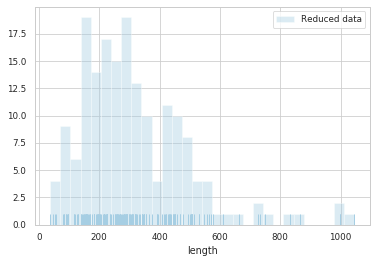

In [322]:
sns.distplot(proteins_df.length, kde=False, rug=True, bins=30, label="Reduced data")
#sns.distplot(pd.read_sql_query("select * from proteins", conn).length, kde=True, label="Original data")
plt.legend()

# Benchmark helper functions

## Measures

In [323]:
def exp2name(exp):
    for m, name in method_mapping:
        if exp.lower().startswith(m):
            return name
    return f'MISSING {exp}'

def exp2order(exp):
    for i, (m, name) in enumerate(method_mapping):
        if exp.lower().startswith(m):
            return i
    return f'MISSING {exp}'

In [324]:
def measures_cont(df, filename=None):
    measures = [pearsonr, mean_absolute_error, mean_squared_error, lambda x, y: math.sqrt(mean_squared_error(x, y))]
    measure_names = ['r', 'MAE', 'MSE', 'RMSE']
    obs = df[df.experiment == "observed"].val_0
    benchmarks = {}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment].val_0
        for i, measure in enumerate(measures):
            result = measure(obs, pred)
            if isinstance(result, list) or isinstance(result, tuple):
               
                if not measure_names[i] in benchmarks:
                    benchmarks[measure_names[i]] = []
                benchmarks[measure_names[i]].append(round(result[i], 2))
                #for i in range(len(result)):
                #    if not "{}_{}".format(measure.__name__, i) in benchmarks:
                #        benchmarks["{}_{}".format(measure.__name__, i)] = []
                #    benchmarks["{}_{}".format(measure.__name__, i)].append(round(result[i], 3))
            else:
                if not measure_names[i] in benchmarks:
                    benchmarks[measure_names[i]] = []
                benchmarks[measure_names[i]].append(round(result, 2))
    
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="MAE").style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

In [325]:
def measures_bin(df, filename=None):
    measures = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef]
    measure_names = ['ACC', 'P', 'R', 'F1', 'AUC', 'MCC']
    obs = df[df.experiment == "observed"].val_0
    benchmarks = {measure: [] for measure in measure_names}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment].val_0.round()
        for i, measure in enumerate(measures):
            benchmarks[measure_names[i]].append(round(measure(obs, pred), 2))
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="ACC", ascending=False).style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

In [326]:
def measures_cat(df, num_classes=3, class_names=None, filename=None):
    if class_names is None:
        class_names = [i for i in range(num_classes)]
        
    measures_all = [accuracy_score]
    measures_class = [precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef]
    measure_all_names = ['ACC']
    measure_names = ['P', 'R', 'F1', 'AUC', 'MCC']
    
    obs = df[df.experiment == "observed"][["val_{}".format(x) for x in range(num_classes)]]
    
    #benchmarks = {measure.__name__: [] for measure in measures_all + measures_class}
    benchmarks = {measure: [] for measure in measure_all_names}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment][["val_{}".format(x) for x in range(num_classes)]]
        pred_argmax = np.array(pred).argmax(axis=1)
        for i, measure in enumerate(measures_all):
            benchmarks[measure_all_names[i]].append(round(measure(np.array(obs).argmax(axis=1), pred_argmax), 2))
        
        obs_rounded = np.array(obs)
        pred_rounded = np.zeros(pred.shape)
        for i, argmax in enumerate(pred_argmax):
            pred_rounded[i, argmax] = 1
           
        
            
            #class_results = []
        for i in range(num_classes):
            for m, measure in enumerate(measures_class):
                if not "{} ({})".format(class_names[i], measure_names[m]) in benchmarks:
                    benchmarks["{} ({})".format(class_names[i], measure_names[m])] = []
                benchmarks["{} ({})".format(class_names[i], measure_names[m])].append(round(measure(obs_rounded[:, i], pred_rounded[:, i]), 2))
                #class_results.append(round(measure(obs_rounded[:, i], pred_rounded[:, i]), 3))
            #benchmarks[measure.__name__].append(class_results)
        
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="ACC", ascending=False).style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

<h2>Plots</h2>

In [327]:
def plots_cont(df, xlab, ylab, filename=None, hist=False, kde=True):
    fig, ax = plt.subplots(1, 1, figsize=(one_col_fig_width, one_col_fig_width))
    #min_val = df.val_0.min()
    #max_val = df.val_0.max()
    #axs[1].set(xlim=(min_val, max_val), ylim=(min_val, max_val))
    for experiment in sorted(df.experiment.unique(), key=exp2order):
        kde_kws = {}
        color = None
        if experiment == "observed":
            #hist = True
            color='black'
            kde_kws["lw"] = 4
        else:
            pass
            #sns.kdeplot(df[df.experiment == 'observed'].val_0, df[df.experiment == experiment].val_0, label=experiment, ax=axs[1])
            #sns.regplot(df[df.experiment == 'observed'].val_0, df[df.experiment == experiment].val_0, label=experiment, ax=axs[1], scatter=False)
        sns.distplot(df[df.experiment == experiment].val_0, label=exp2name(experiment), hist=hist, kde=kde, color=color, ax=ax, kde_kws=kde_kws)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.legend(frameon=True, facecolor='white', framealpha=0.8)
    #axs[1].set(xlabel='Observed', ylabel='Predicted')
    #axs[1].legend()
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

In [328]:
def plots_bin(obs_df, dfs, filename=None):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(two_col_fig_width, two_col_fig_width/2)
    for a in ax:
        a.set_xlim([0, 1])
        a.set_ylim([0, 1])
    
    obs = obs_df[obs_df.experiment == "observed"].val_0
    
    for name, df in dfs.items():
        for experiment in sorted(df[df.experiment != "observed"].experiment.unique(), key=exp2order):
            pr = precision_recall_curve(obs, df[df.experiment == experiment].val_0)
            ax[0].plot(pr[1], pr[0], label=exp2name(experiment))

            roc = roc_curve(obs, df[df.experiment == experiment].val_0)
            ax[1].plot(roc[0], roc[1], label=exp2name(experiment))

    ax[0].set(xlabel="Recall", ylabel="Precision")
    #ax[0].legend()
    ax[1].set(xlabel="FPR or (1 - specificity)", ylabel="TPR or sensitivity")
    ax[1].legend(frameon=True, facecolor='white', framealpha=0.8)
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

In [329]:
def plots_cat(obs_df, dfs, num_classes=3, filename=None, class_names=None):
    fig, ax = plt.subplots(num_classes, 2)
    fig.set_size_inches(two_col_fig_width, two_col_fig_width / 2 * num_classes)
    for a in ax:
        for b in a:
            b.set_xlim([0, 1])
            b.set_ylim([0, 1])
            
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]
    
    obs_rounded = obs_df[obs_df.experiment == "observed"][["val_{}".format(x) for x in range(num_classes)]].values
    
    for name, df in dfs.items():
        for experiment in sorted(df[df.experiment != "observed"].experiment.unique(), key=exp2order):
            pred = df[df.experiment == experiment][["val_{}".format(x) for x in range(num_classes)]]
            pred_argmax = np.array(pred).argmax(axis=1)
            
            pred_rounded = pred.values
            #pred_rounded = np.zeros(pred.shape)
            #for i, argmax in enumerate(pred_argmax):
            #    pred_rounded[i, argmax] = 1
                
            for i in range(num_classes):
                pr = precision_recall_curve(obs_rounded[:, i], pred_rounded[:, i])
                ax[i][0].plot(pr[1], pr[0], label=exp2name(experiment))

                roc = roc_curve(obs_rounded[:, i], pred_rounded[:, i])
                ax[i][1].plot(roc[0], roc[1], label=exp2name(experiment))

                ax[i][0].set(xlabel="Recall", ylabel="Precision")
                ax[i][1].set(xlabel="FPR or (1 - specificity)", ylabel="TPR or sensitivity")
                #ax[i][0].legend()
                if i == 0:
                    ax[i][1].legend(frameon=True, facecolor='white', framealpha=0.8)
                    
                ax[i][0].annotate(class_names[i], (0.1, 0.1), horizontalalignment='center', verticalalignment='center', fontsize='xx-large')
                
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

<h1>Bfactors</h1>

<h2>Bfactors continuous</h2>

In [ ]:
bfactors_cont = pd.read_sql_query(f"select * from mllib_features_continuous_bfactors join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
bfactors_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(bfactors_cont, filename='bfactors_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(bfactors_cont, "Normalized B-factors", "Density", filename='bfactors_cont')

fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.27)
sns.distplot(raw_df.bfactor, ax=ax)
ax.set(xlabel="Raw B-factors", ylabel="Density")
ax.legend()

<h2>Bfactors binary</h2>

In [ ]:
bfactors_bin = pd.read_sql_query(f"select * from mllib_features_binary_bfactors join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
bfactors_bin.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_bin(bfactors_bin, filename='bfactors_bin')

<h3>Benchmark curves</h3>

In [ ]:
plots_bin(bfactors_bin, {"bin": bfactors_bin}, filename='bfactors_bin')

# Bfactors - TMS

<h2>Bfactors continuous</h2>

In [ ]:
bfactors_cont_tms = pd.read_sql_query(f"select p.experiment, p.id, p.resi, p.val_0 from mllib_features_continuous_bfactors as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
bfactors_cont_tms.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(bfactors_cont_tms, filename='bfactors_cont_tms')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(bfactors_cont_tms, "Normalized B-factors", "Density", filename='bfactors_cont_tms')

fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.27)
sns.distplot(raw_df.bfactor, ax=ax)
ax.set(xlabel="Raw Bfactors", ylabel="Density")
ax.legend()

<h2>Bfactors binary</h2>

In [ ]:
bfactors_bin_tms = pd.read_sql_query(f"select p.experiment, p.id, p.resi, p.val_0 from mllib_features_binary_bfactors as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
bfactors_bin_tms.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_bin(bfactors_bin_tms, filename='bfactors_bin_tms')

<h3>Benchmark curves</h3>

In [ ]:
plots_bin(bfactors_bin_tms, {"bin": bfactors_bin_tms}, filename='bfactors_bin_tms')

<h1>Z-coordinates</h1>

<h2>Z-coordinates continuous</h2>

In [ ]:
zcoords_cont = pd.read_sql_query(f"select * from mllib_features_continuous_ZCoordinates join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
zcoords_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(zcoords_cont, filename='zcoords_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(zcoords_cont, "Z-coordinate", "Density", filename='zcoords_cont')

In [ ]:
plots_cont(zcoords_cont, "Z-coordinate", "Density", filename='hist_zcoords_cont', hist=True, kde=False)

# Topology

In [ ]:
zcoords_cat = pd.read_sql_query(f"select * from mllib_features_categorical_Topology join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
zcoords_cat.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cat(zcoords_cat, 4, class_names=['In', 'TMS', 'Out', 'RER'], filename='zcoords_cat')

<h3>Benchmark plots</h3>

In [ ]:
 plots_cat(zcoords_cat, {"cat": zcoords_cat}, num_classes=4, filename='zcoords_cat', class_names=['In', 'TMS', 'Out', 'RER'])

<h1>Phi angles</h2>

<h2>Phi angles continuous</h2>

In [ ]:
phi_cont = pd.read_sql_query(f"select * from mllib_features_continuous_PhiAngles join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
phi_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(phi_cont, filename='phi_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(phi_cont, "Phi angle", "Density", filename='phi_cont')

<h1>Psi angles</h2>

<h2>Psi angles continuous</h2>

In [ ]:
psi_cont = pd.read_sql_query(f"select * from mllib_features_continuous_PsiAngles join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
psi_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(psi_cont, filename='psi_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(psi_cont, "Psi angle", "Density", filename='psi_cont')

In [ ]:
#sns.kdeplot(phi_cont[phi_cont.experiment == 'observed'].val_0.values, psi_cont[psi_cont.experiment == 'observed'].val_0.values)

# Secondary structure

In [ ]:
sec_cat = pd.read_sql_query(f"select * from mllib_features_categorical_SecStruc join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
sec_cat.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cat(sec_cat, 3, class_names=['H', 'E', 'C'], filename='sec_cat')

<h3>Benchmark plots</h3>

In [ ]:
 plots_cat(sec_cat, {"cat": sec_cat}, filename='sec_cat', class_names=['H', 'E', 'C'])

# Secondary structure WITHOUT TMS

In [ ]:
sec_cat_notms = pd.read_sql_query(f"select p.experiment, p.resi, p.val_0, p.val_1, p.val_2 from mllib_features_categorical_SecStruc as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo!='T' and topo !='R' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)


<h3>Data description</h3>

In [ ]:
sec_cat_notms.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cat(sec_cat_notms, 3, class_names=['H', 'E', 'C'], filename='sec_cat_notms')

<h3>Benchmark plots</h3>

In [ ]:
 plots_cat(sec_cat_notms, {"cat": sec_cat_notms}, filename='sec_cat_notms', class_names=['H', 'E', 'C'])

# RSA

<h2>RSA complex</h2>

In [ ]:
rsa_comp_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaComplex join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
rsa_comp_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(rsa_comp_cont, filename='rsa_comp_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(rsa_comp_cont, "RSA complex", "Density", filename='rsa_comp_cont')

# RSA chain

In [ ]:
rsa_chain_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaChain join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
rsa_chain_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(rsa_chain_cont, filename='rsa_chain_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(rsa_chain_cont, "RSA monomer", "Density", filename='rsa_chain_cont')

# RSA diff

In [ ]:
rsa_diff_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaDiff join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [ ]:
rsa_diff_cont.groupby("experiment").describe()

<h3>Benchmark measures</h3>

In [ ]:
measures_cont(rsa_diff_cont, filename='rsa_diff_cont')

<h3>Benchmark plots</h3>

In [ ]:
plots_cont(rsa_diff_cont, "RSA change", "Density", filename='rsa_diff_cont')

# Others

In [ ]:
history = json.loads(conn.cursor().execute('select history from experiments where experiment="keras_all_targets" and fold=0').fetchone()[0])
history.keys()

In [ ]:
plt.plot(range(len(history['loss'])), history['loss'])
plt.plot(range(len(history['val_loss'])), history['val_loss'])
plt.plot(range(len(history['lr'])), np.log(history['lr']) - np.min(np.log(history['lr'])))

In [ ]:
import sys
sys.path.append('..')

In [ ]:
from mllib.features.continuous import Pssm, Pssm2
from mllib.retrievers import SQLRetriever

In [ ]:
vals = []
vals2 = []
for idx in conn.cursor().execute('select id from alignments limit 20'):
    print(idx)
    #vals.extend(Pssm().transform(SQLRetriever(conn, Pssm.query).transform(idx[0])).flatten())
    #vals2.extend(Pssm2().transform(SQLRetriever(conn, Pssm.query).transform(idx[0])).flatten())
    
#msa = SQLRetriever(conn, Pssm.query).transform('1kpl_B')
#%time Pssm().transform(msa)

In [ ]:
len(vals), len(vals2)

In [ ]:
vals = np.array(vals)
vals2 = np.array(vals2)

In [ ]:
def normalize(xs):
    return list(map(lambda x: 1 / (1 + np.exp(-1 * x)), xs))
                
hist = True
kde = False
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(vals / 2 + 0.5, label='pssm', hist=hist, kde=kde, ax=axs[0])
sns.distplot(vals2, label='pssm2', hist=hist, kde=kde, ax=axs[1])
plt.legend()

In [ ]:
xxx = pd.read_sql_query('select phi, psi from raw_data', conn)

In [ ]:
xxx.describe()

In [ ]:
print(math.pi)